![example](images/director_shot.jpeg)

# Project Title

## **Author:** Madeleine Reiser
***

## Overview

This project used exploratory data analysis to help the business stake owners of a potential new movie streaming service figure out the best ways to make box office revenue. Datasets from IMDB and Box Office Mojo were analyzed to show what movies have made the most money, which are the highest rated, and which are the most popular, from the years 2010-2018. 

## Business Problem

Microsoft Stake Owners are interested in developing their own streaming service but aren’t sure what kinds of movies do the best in the box office. 


## Data Understanding

Using datasets from IMDB and Box Office Mojo, this project explores how box office revenue is correlated with variables such as ratings, popularity (which is measured by number of reviews left by viewers), specific studios and genres.  


## Import necessary packages and load Datasets

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import requests
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [266]:
#load data 
imdb_title_ratings = pd.read_csv('imdb.title.ratings.csv.gz')
imdb_title_basics = pd.read_csv('imdb.title.basics.csv.gz')
bom_movie_gross = pd.read_csv('bom.movie_gross.csv.gz')

## IMDB Ratings Dataset

Contains "tconst", which appears to be the code for each movie, the film's average rating, and the number of votes on IMDB

In [267]:
imdb_title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [268]:
imdb_title_ratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## IMDB Basic Dataset

Contains more information for each film on IMDB including "tconst" again, Primary and Original titles, start year, runtime in minutes, and the genre. 

In [269]:
imdb_title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


## Box Office Mojo dataset

Contains the title, studio, domestic gross, foreign gross and year released according to data from Box Office Mojo 

In [270]:
bom_movie_gross.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [271]:
bom_movie_gross.describe()


,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Box Office Mojo dataset

In [272]:
bom_movie_gross = pd.read_csv('bom.movie_gross.csv.gz')
bom_movie_gross.sort_values(by='year', ascending=False)
bom_movie_gross.sort_values(by='domestic_gross', ascending=False).head(30)
bom_movie_gross.info()
#last year is 2018
#includes studio
#foreign_gross is an object
bom_movie_gross.columns = ['Title', 'Studio', 'Domestic Gross', 
                        'Foreign Gross', 'BOM Year']
bom_movie_gross

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,Title,Studio,Domestic Gross,Foreign Gross,BOM Year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


## Merging the two IMDB Sets

I merged both IMDB Datasets to keep all IMDB data together. 

In [273]:
#Join imdb_title_basics and imdb_title_ratings 
imdb_ratings_joined = imdb_title_basics.merge(imdb_title_ratings, on = 'tconst',  how = 'outer')
imdb_ratings_joined.sort_values(by = 'start_year', ascending = False)
#data begins at 2010 and goes up to 2115, limit year to 2010-2018


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
89506,tt5174640,100 Years,100 Years,2115,NaN,Drama,NaN,NaN
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy",NaN,NaN
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy,NaN,NaN
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy",NaN,NaN
105187,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy",NaN,NaN
...,...,...,...,...,...,...,...,...
74712,tt4264626,Civil War Life: Shot to Pieces,Civil War Life: Shot to Pieces,2010,79.0,Documentary,5.7,6.0
14471,tt1716746,Heinrich Kieber - Datendieb,Heinrich Kieber - Datendieb,2010,52.0,Documentary,7.7,6.0
74692,tt4263706,Mushrooms of America,Mushrooms of America,2010,46.0,"Adventure,Comedy,Documentary",NaN,NaN
118065,tt7059624,Zamana,Zamana,2010,140.0,Drama,NaN,NaN


I renamed the columns to make them more readable. 

In [274]:
imdb_ratings_joined.columns = ['tconst', 'Title', 'Original Title', 
                               'IMDB Year', 'Runtime (in minutes)', 
                              'Genres', 'Average Rating', 'Number of Votes']
imdb_ratings_joined.sort_values(by = 'IMDB Year')

,tconst,Title,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
9599,tt1566491,Brainiacs in La La Land,Brainiacs in La La Land,2010,NaN,Comedy,NaN,NaN
43264,tt2578092,Fireplace for your Home: Crackling Fireplace w...,Fireplace for your Home: Crackling Fireplace w...,2010,61.0,Music,6.9,17.0
11550,tt1634300,Role/Play,Role/Play,2010,85.0,"Drama,Romance",5.0,894.0
11551,tt1634332,Johan1,Johan Primero,2010,78.0,"Comedy,Drama,Romance",7.1,124.0
11552,tt1634334,Hands Up,Les mains en l'air,2010,90.0,Drama,6.2,271.0
...,...,...,...,...,...,...,...,...
2948,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,NaN,NaN,NaN,NaN
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy",NaN,NaN
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy,NaN,NaN
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy",NaN,NaN


I limited the data from the joined IMDB datasets to 2018, which is the last year this set was updated. 

In [275]:
#get relevant years (2010-2018) 
imdb_ratings_joined2010_2018 = imdb_ratings_joined.loc[imdb_ratings_joined['IMDB Year'] <= 2018]
imdb_ratings_joined2010_2018.sort_values(by = 'IMDB Year', ascending = False)
imdb_ratings_joined2010_2018.sort_values(by = 'Average Rating', ascending = False)



,tconst,Title,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
85712,tt4960818,Revolution Food,Revolution Food,2015,70.0,Documentary,10.0,8.0
117359,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,A Dedicated Life: Phoebe Brand Beyond the Group,2015,93.0,Documentary,10.0,5.0
44279,tt2632430,Hercule contre Hermès,Hercule contre Hermès,2012,72.0,Documentary,10.0,5.0
4016,tt10378660,The Dark Knight: The Ballad of the N Word,The Dark Knight: The Ballad of the N Word,2018,129.0,"Comedy,Drama",10.0,5.0
1857,tt10176328,Exteriores: Mulheres Brasileiras na Diplomacia,Exteriores: Mulheres Brasileiras na Diplomacia,2018,52.0,Documentary,10.0,5.0
...,...,...,...,...,...,...,...,...
146136,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,Documentary,NaN,NaN
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,NaN,NaN
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN,NaN,NaN


I dropped rows where average rating is NaN


In [276]:
rating_na_dropped = imdb_ratings_joined2010_2018[imdb_ratings_joined2010_2018['Average Rating'].notna()]


I limited the average rating to 8 or better, and show the value counts per genre. This merged dataset doesn't include data from BOM, only IMDB.

In [434]:
#limit average rating to 8 or better
rating_na_dropped.loc[rating_na_dropped['Average Rating'] >= 8]
imdb_8_or_better = rating_na_dropped.loc[rating_na_dropped['Average Rating'] >= 8]
#genres where rating was better than an 8
imdb_8_or_better['Genres'].value_counts().head(10)


Documentary                      2715
Drama                            1234
Comedy                            402
Comedy,Drama                      220
Documentary,Music                 204
Documentary,Drama                 158
Biography,Documentary             155
Biography,Documentary,History     142
Documentary,History               131
Biography,Documentary,Drama       117
Name: Genres, dtype: int64

## Merge the BOM dataset with the IMDB dataset

Joined the tables by 'Title', and dropped the year given by BOM since we already have the year from IMDB, which provides most of the data. 

In [431]:
alljoined = bom_movie_gross.merge(rating_na_dropped, on = 'Title',  how = 'inner')
alljoined
#sort by # votes, gives best idea of rating
alljoined.sort_values(by = 'Domestic Gross', ascending = False)


#dropping BOM year because it has the least entries and most of 
#the data is from IMDB 
alljoined.drop_duplicates()
alljoined.drop(['BOM Year'], axis='columns', inplace=True)
alljoined.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3015 non-null   object 
 1   Studio                3012 non-null   object 
 2   Domestic Gross        2993 non-null   float64
 3   Foreign Gross         1821 non-null   object 
 4   tconst                3015 non-null   object 
 5   Original Title        3015 non-null   object 
 6   IMDB Year             3015 non-null   int64  
 7   Runtime (in minutes)  2970 non-null   float64
 8   Genres                3008 non-null   object 
 9   Average Rating        3015 non-null   float64
 10  Number of Votes       3015 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 282.7+ KB


I further sliced the dataset to limit results to any films with an average rating of 8 or better to explore which films are highest rated

In [432]:
alljoined_8_or_better = alljoined.loc[alljoined['Average Rating'] >= 8]
#limit alljoined table to ratings 8 or better
alljoined_8_or_better.sort_values(by = 'Average Rating')
alljoined_8_or_better['Genres'].value_counts()

Drama                         18
Documentary                   10
Adventure,Animation,Comedy     4
Action,Adventure,Sci-Fi        4
Comedy                         3
                              ..
Mystery,Thriller               1
Crime,Drama,Mystery            1
Adventure,Comedy,Crime         1
Drama,History,War              1
Documentary,Family             1
Name: Genres, Length: 69, dtype: int64

In [280]:
alljoined.sort_values(by = 'Domestic Gross', ascending = False)

,Title,Studio,Domestic Gross,Foreign Gross,tconst,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
2740,Black Panther,BV,700100000.0,646900000,tt1825683,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0
2739,Avengers: Infinity War,BV,678800000.0,"1,369.5",tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
1608,Jurassic World,Uni.,652300000.0,"1,019.4",tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0
2424,Star Wars: The Last Jedi,BV,620200000.0,712400000,tt2527336,Star Wars: Episode VIII - The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",7.1,462903.0
2742,Incredibles 2,BV,608600000.0,634200000,tt3606756,Incredibles 2,2018,118.0,"Action,Adventure,Animation",7.7,203510.0
...,...,...,...,...,...,...,...,...,...,...,...
2162,Solace,LGP,NaN,22400000,tt2140411,Solace,2013,76.0,Thriller,7.2,59.0
2163,Solace,LGP,NaN,22400000,tt3240102,Solace,2018,81.0,Drama,4.9,28.0
2281,Viral,W/Dim.,NaN,552000,tt2594078,Viral,2013,95.0,"Comedy,Horror,Thriller",4.4,227.0
2282,Viral,W/Dim.,NaN,552000,tt2597892,Viral,2016,85.0,"Drama,Horror,Sci-Fi",5.5,7150.0


In [281]:
alljoined = bom_movie_gross.merge(rating_na_dropped, on = 'Title',  how = 'inner')
alljoined['Foreign Gross'] = pd.to_numeric(alljoined['Foreign Gross'], errors = 'coerce')
alljoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3015 non-null   object 
 1   Studio                3012 non-null   object 
 2   Domestic Gross        2993 non-null   float64
 3   Foreign Gross         1817 non-null   float64
 4   BOM Year              3015 non-null   int64  
 5   tconst                3015 non-null   object 
 6   Original Title        3015 non-null   object 
 7   IMDB Year             3015 non-null   int64  
 8   Runtime (in minutes)  2970 non-null   float64
 9   Genres                3008 non-null   object 
 10  Average Rating        3015 non-null   float64
 11  Number of Votes       3015 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 306.2+ KB


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

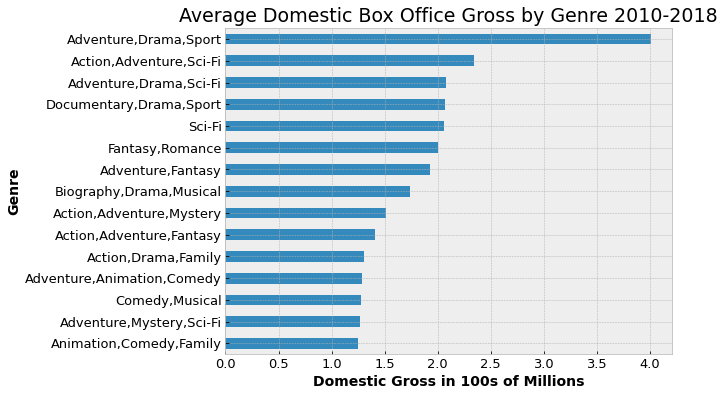

In [363]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Genres'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh', figsize = (8,6))
    plt.title('Average Domestic Box Office Gross by Genre 2010-2018', fontsize = 19)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold') 
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
#highest grossing genre is Adventure/Drama/Sport

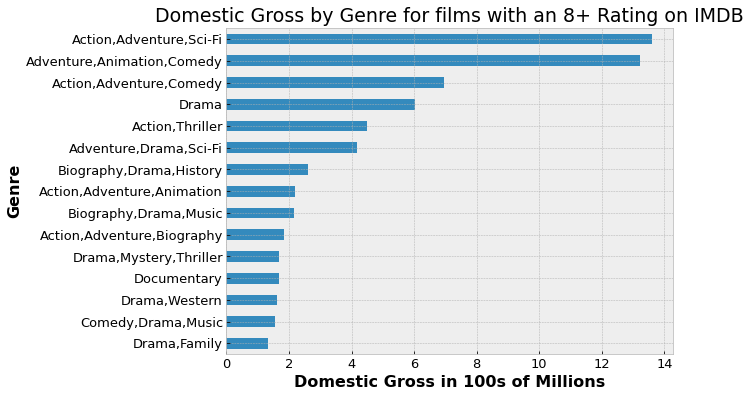

In [361]:
with plt.style.context('bmh'):
    (alljoined_8_or_better.groupby(['Genres'])['Domestic Gross'].sum().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh', figsize = (8,6))
    plt.title('Domestic Gross by Genre for films with an 8+ Rating on IMDB', fontsize = 19)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of Millions', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 16, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

#if you care about ratings, Action, Thriller, Adventure, Sci-Fi is the way to go 

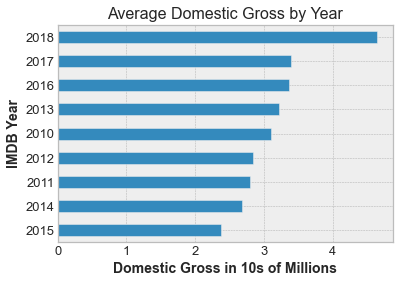

In [438]:
with plt.style.context('bmh'):
    (alljoined.groupby(['IMDB Year'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/10000000).plot(kind = 'barh')
    plt.title('Average Domestic Gross by Year', fontsize = 16)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 10s of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('IMDB Year', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
#why 2018 so high?  

In [286]:
just2018 = alljoined[alljoined['IMDB Year'] == 2018]
just2018['Genres'].value_counts()

Drama                         23
Comedy,Drama,Romance           7
Comedy                         7
Adventure,Animation,Comedy     6
Drama,Romance                  6
                              ..
Drama,History,Sport            1
Action,Fantasy,Horror          1
Adventure,Animation,Drama      1
Comedy,Crime                   1
Fantasy,Horror,Mystery         1
Name: Genres, Length: 88, dtype: int64

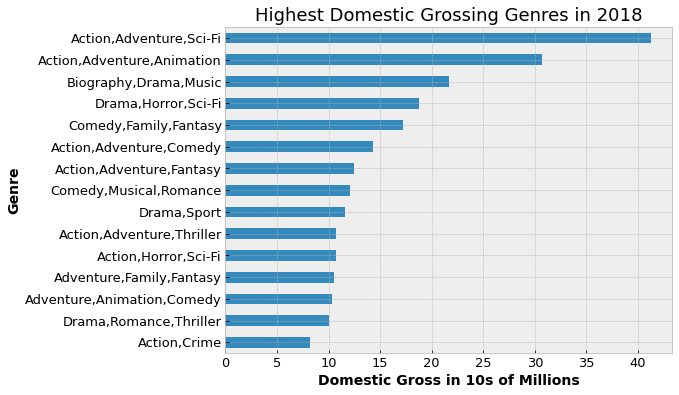

In [414]:
with plt.style.context('bmh'):
    (just2018.groupby(['Genres'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/10000000).plot(kind = 'barh', figsize = (8,6))
    plt.title('Highest Domestic Grossing Genres in 2018', fontsize = 18)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 10s of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
#action/adventure/scifi


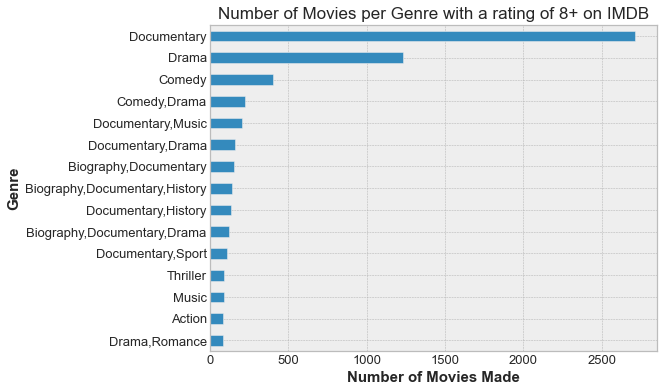

In [436]:
with plt.style.context("bmh"):
    imdb_8_or_better['Genres'].value_counts().head(15).plot(kind = 'barh', figsize = (8,6))
    plt.title('Number of Movies per Genre with a rating of 8+ on IMDB', fontsize = 17)
    plt.xlabel('Number of Movies Made', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 15, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.gca().invert_yaxis()

#if you're after ratings and don't necessarily care about popularity or gross income
#number of votes should be considered for a better idea 
#average number of votes per genres

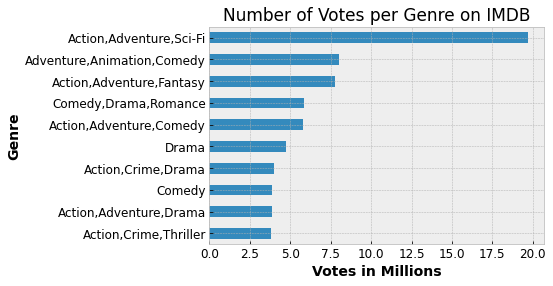

In [396]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Genres'])['Number of Votes'].sum().sort_values(ascending = False).head(10)/1000000).plot(kind = 'barh')
    plt.title('Number of Votes per Genre on IMDB', fontsize = 17)
    plt.gca().invert_yaxis()
    plt.xlabel('Votes in Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
#adventure/drama/sci fi draws more feedback than any, important because of the correlation between average votes and domestic gross

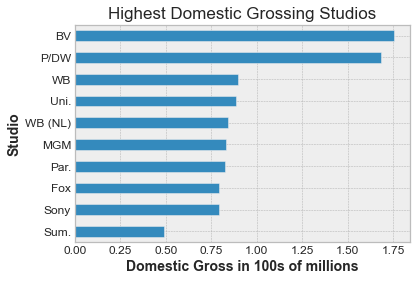

In [437]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Studio'])['Domestic Gross'].mean().sort_values(ascending = False).head(10)/100000000).plot(kind = 'barh')
    plt.title('Highest Domestic Grossing Studios', fontsize = 17)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Studio', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

In [291]:
BVonly = alljoined[alljoined['Studio']== 'BV']
PDWonly = alljoined[alljoined['Studio']== 'P/DW']
WBonly = alljoined[alljoined['Studio']== 'WB']

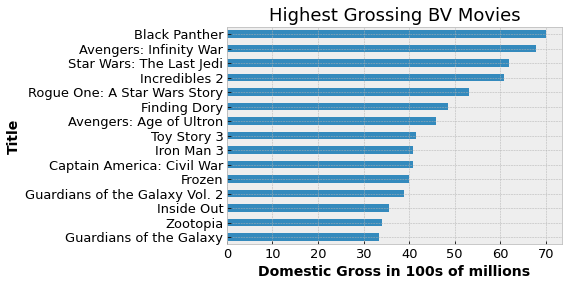

In [409]:
BVonly['Genres'].value_counts()

with plt.style.context('bmh'):
    (BVonly.groupby(['Title'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/10000000).plot(kind = 'barh')
    plt.title('Highest Grossing BV Movies', fontsize = 18)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

Action,Adventure,Animation    4
Adventure,Animation,Comedy    2
Comedy                        1
Action,Animation,Comedy       1
Comedy,Drama                  1
Action,Adventure,Sci-Fi       1
Name: Genres, dtype: int64

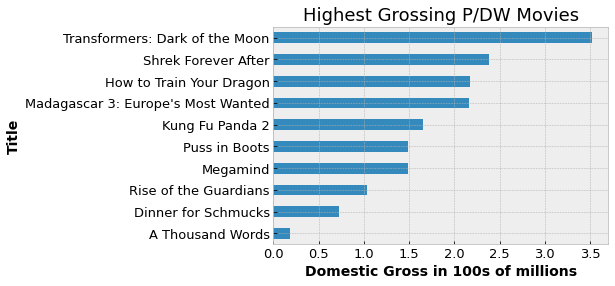

In [410]:
with plt.style.context('bmh'):
    (PDWonly.groupby(['Title'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Highest Grossing P/DW Movies', fontsize = 18)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    
PDWonly['Genres'].value_counts() 

Action,Adventure,Fantasy      9
Action,Adventure,Sci-Fi       7
Drama                         4
Comedy,Drama,Romance          4
Adventure,Animation,Comedy    4
                             ..
Action,Adventure,Biography    1
Drama,Fantasy,Romance         1
Fantasy,Horror,Mystery        1
Action,Biography,Drama        1
Adventure,Comedy,Drama        1
Name: Genres, Length: 66, dtype: int64

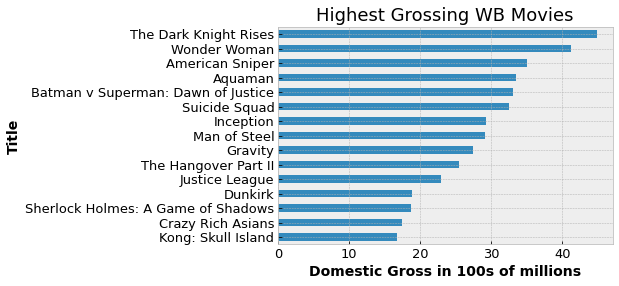

In [411]:
with plt.style.context('bmh'):
    (WBonly.groupby(['Title'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/10000000).plot(kind = 'barh')
    plt.title('Highest Grossing WB Movies', fontsize = 18)
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

WBonly['Genres'].value_counts()


[Text(0, 0.5, 'Domestic Gross'),
 Text(0, 1.5, 'Foreign Gross'),
 Text(0, 2.5, 'BOM Year'),
 Text(0, 3.5, 'IMDB Year'),
 Text(0, 4.5, 'Runtime (in minutes)'),
 Text(0, 5.5, 'Average Rating'),
 Text(0, 6.5, 'Number of Votes')]

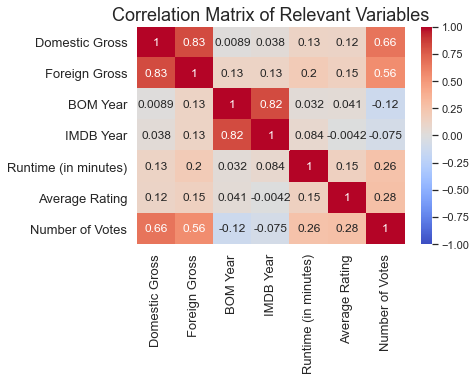

In [430]:
ax = plt.axes()
sns.set(font_scale = 1)
sns.heatmap(alljoined.corr(), ax = ax, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

ax.set_title('Correlation Matrix of Relevant Variables', fontsize = 18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 13)

#Notable correlations: 
#Domestic & Foreign Gross = .83 
#Num Votes & FG = .56
#Num Votes & DG = .66
#Average Rating & Num Votes = .28

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***